In [31]:
#Libraries
import json
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [32]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O /tmp/sarcasm.json

with open("/tmp/sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = [] 
labels = []
urls = []
for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

--2020-12-15 17:49:55--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.215.128, 173.194.216.128, 173.194.217.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.215.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.03s   

2020-12-15 17:49:55 (199 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



In [33]:
#Hyperparameters
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000


To split the corpus into training and validation sets, we'll use this code. To get the training set, you take array items from zero to the training size, and to get the testing set, you can go from training size to the end of the array with code like this. To get the training and testing labels, you'll use similar codes to slice the labels array. Now that we have training and test sets of sequences and labels, it's time to sequence them. 

In [34]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

Now that we have training and test sets of sequences and labels, it's time to sequence them. To pad those sequences, you'll do that with this code. You start with a tokenizer, passing it the number of words you want to tokenize on and the desired out of vocabulary token. Then fit that on the training set by calling fit on texts, passing it the training sentences array. Then you can use text to sequences to create the training sequence, replacing the words with their tokens. Then you can pad the training sequences to the desired length or truncate if they're too long. Next, you'll do the same but with a test set.

In [35]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [36]:
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [37]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 16)           160000    
_________________________________________________________________
global_average_pooling1d_5 ( (None, 16)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 24)                408       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 25        
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [ ]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
625/625 - 2s - loss: 0.6668 - accuracy: 0.5843 - val_loss: 0.5891 - val_accuracy: 0.7810
Epoch 2/30
625/625 - 2s - loss: 0.4411 - accuracy: 0.8297 - val_loss: 0.3912 - val_accuracy: 0.8337
Epoch 3/30
625/625 - 2s - loss: 0.3169 - accuracy: 0.8744 - val_loss: 0.3539 - val_accuracy: 0.8529
Epoch 4/30
625/625 - 2s - loss: 0.2631 - accuracy: 0.8982 - val_loss: 0.3428 - val_accuracy: 0.8577
Epoch 5/30
625/625 - 2s - loss: 0.2278 - accuracy: 0.9128 - val_loss: 0.3652 - val_accuracy: 0.8429
Epoch 6/30


In [ ]:
import matplotlib.pyplot as plt
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
#Integrating everything inside a function to test different hyperparameters

def NLP_Preparation(training_size,embedding_dim,max_length,trunc_type,padding_type,oov_tok):
  training_sentences = sentences[0:training_size]
  testing_sentences = sentences[training_size:]
  training_labels = labels[0:training_size]
  testing_labels = labels[training_size:]
  tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
  tokenizer.fit_on_texts(training_sentences)

  word_index = tokenizer.word_index

  training_sequences = tokenizer.texts_to_sequences(training_sentences)
  training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

  testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
  testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
  # Need this to get it to work with TensorFlow 2.x
  training_padded = np.array(training_padded)
  training_labels = np.array(training_labels)
  testing_padded = np.array(testing_padded)
  testing_labels = np.array(testing_labels)

  #model

  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
  ])
  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

  print(model.summary())
  
  num_epochs = 30
  history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)
  def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
  plot_graphs(history, "accuracy")
  plot_graphs(history, "loss")


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 16)           32000     
_________________________________________________________________
global_average_pooling1d_3 ( (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 24)                408       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 25        
Total params: 32,433
Trainable params: 32,433
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
625/625 - 1s - loss: 0.6647 - accuracy: 0.5867 - val_loss: 0.5847 - val_accuracy: 0.7468
Epoch 2/30
625/625 - 1s - loss: 0.4652 - accuracy: 0.7986 - val_loss: 0.4131 - val_accuracy: 0.8196
Epoch 3/30
625/625 - 1s - loss: 0.3714 - ac

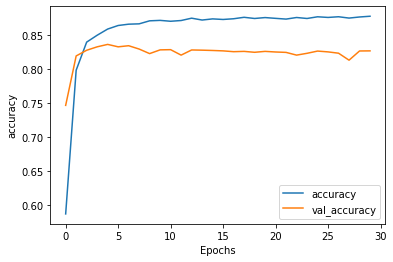

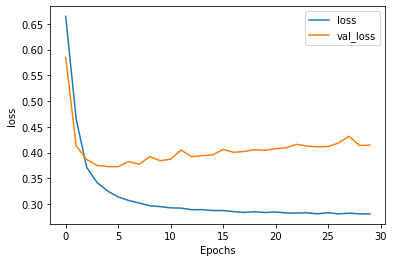

In [29]:
# was 100#2
#Hyperparameters
vocab_size = 2000 # was 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000
#run
NLP_Preparation(training_size,embedding_dim,max_length,trunc_type,padding_type,oov_tok)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 50, 32)            64000     
_________________________________________________________________
global_average_pooling1d_4 ( (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 24)                792       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 25        
Total params: 64,817
Trainable params: 64,817
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
625/625 - 1s - loss: 0.5678 - accuracy: 0.6887 - val_loss: 0.4139 - val_accuracy: 0.8138
Epoch 2/30
625/625 - 1s - loss: 0.3632 - accuracy: 0.8410 - val_loss: 0.3733 - val_accuracy: 0.8337
Epoch 3/30
625/625 - 1s - loss: 0.3271 - ac

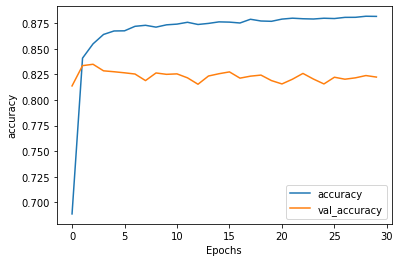

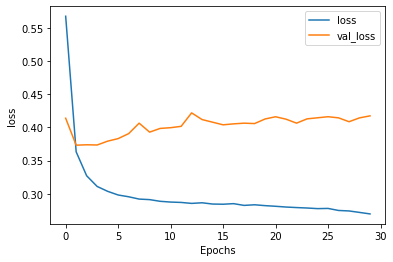

In [30]:
#3
#Hyperparameters
vocab_size = 2000 
embedding_dim = 32 
max_length = 50 # was 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000
#run
NLP_Preparation(training_size,embedding_dim,max_length,trunc_type,padding_type,oov_tok)

#References
-Sarcasm Detection using Hybrid Neural Network. Misra, Rishabh and Arora, Prahal.arXiv preprint arXiv:1908.07414. 

-Coursera Course. Natural Language Processing in TensorFlow by DeepLearning.AI
